In [1]:
from fastai.vision.all import *

###### Problem setup

In [2]:
path = untar_data(URLs.IMAGEWOOF_320)

In [3]:
model = resnet50(pretrained=True).cuda()

/home/molly/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/molly/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
dls = DataBlock((ImageBlock,CategoryBlock),
                splitter=IndexSplitter([0,2]),
                item_tfms=Resize(320),
                batch_tfms=aug_transforms(),
                get_items=get_image_files).dataloaders(path)

In [5]:
def model_call(model,x):
    #same as model.forward
        x = model.conv1(x)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.maxpool(x)

        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)

        #x = model.avgpool(x)
        #x = torch.flatten(x, 1)
        #x = model.fc(x)
        return x

In [6]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [7]:
#model_call(model,dls.one_batch()[0])

Going to use a relatively small number of buckets, could use much more if we wanted to have less total collisions. 

In [8]:
nbits=8
buckets=2**nbits
bits=torch.arange(0,8,device='cuda')
nbits,buckets,2.**bits

(8,
 256,
 tensor([  1.,   2.,   4.,   8.,  16.,  32.,  64., 128.], device='cuda:0'))

In [9]:
bits

tensor([0, 1, 2, 3, 4, 5, 6, 7], device='cuda:0')

In [10]:
torch.sum(2**bits)

tensor(255, device='cuda:0')

###### How would we calculate the maximum value that we can represent?

In [11]:
[64, 2048, 10, 10]

[64, 2048, 10, 10]

In [12]:
[64, 8, 10, 10]

[64, 8, 10, 10]

In [13]:
(2.**bits).sum()

tensor(255., device='cuda:0')

In [14]:
#dividing by nbits gets us close to 1
projector=torch.randn(2048,nbits).cuda()/nbits**0.5
torch.linalg.norm(projector,dim=1)

tensor([1.0337, 1.0348, 1.0620,  ..., 1.0139, 1.1947, 1.1155], device='cuda:0')

In [15]:
nbits

8

In [16]:
[0,1,0,0,0], [0,0,1,0,0],[1,0,0,0,0]

([0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0])

In [17]:
b=dls.one_batch()[0]

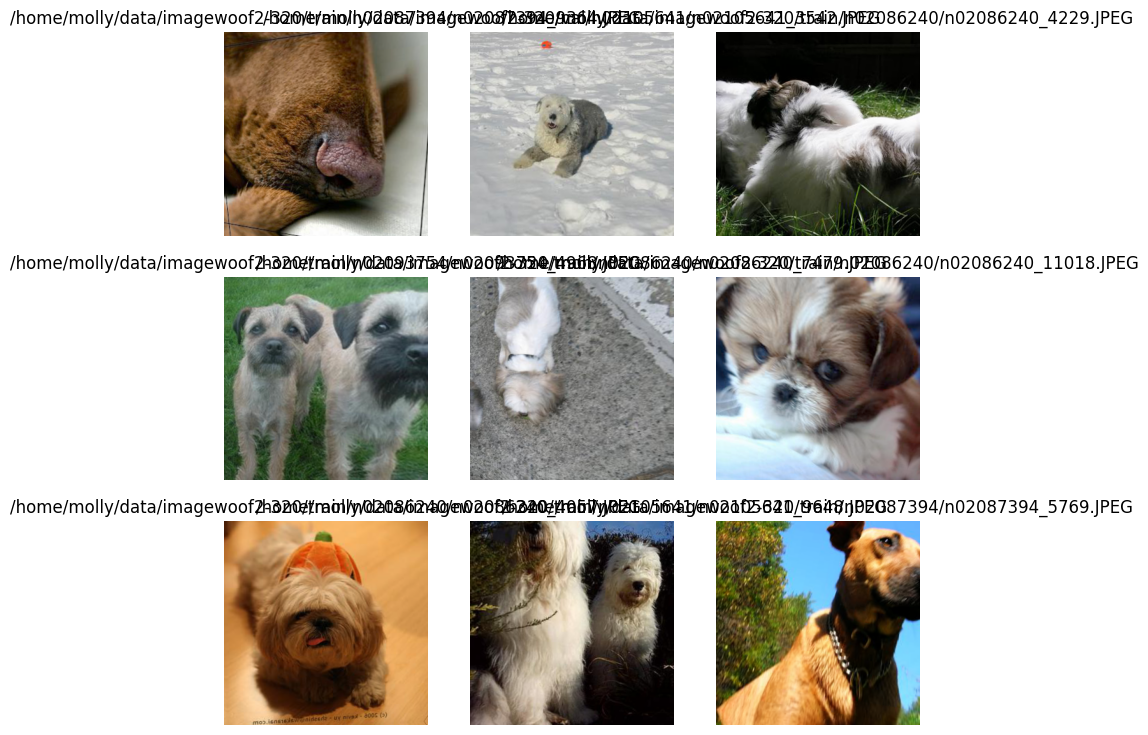

In [18]:
dls.show_batch()

In [19]:
ys=model_call(model,b)

In [36]:
(ys[:,:,None]*projector[None,...,None,None]).shape

torch.Size([64, 2048, 8, 10, 10])

In [30]:
ys.shape,projector.shape

(torch.Size([64, 2048, 10, 10]), torch.Size([2048, 8]))

In [31]:
torch.einsum('ijkl,jm->imkl',ys,projector).shape

torch.Size([64, 8, 10, 10])

In [41]:
(torch.einsum('ijkl,jm->ijmkl',ys,projector)==(ys[:,:,None]*projector[None,...,None,None])).any()

TensorImage(True, device='cuda:0')

##### How would you calculate the dot product for the second dim and first dim? (2048,10,10)@(2048,8)=(8,10,10)

###### Using Einstein notation? 

In [32]:
projection=torch.einsum('bcxy,cz->bzxy',ys,projector)

In [42]:
projection

TensorImage([[[[-6.2792e+00,  1.3167e-01, -9.4779e-02,  ..., -2.4656e+00,
                -5.0584e+00, -1.3296e+00],
               [ 8.1754e+00,  9.6036e+00, -4.4357e+00,  ..., -4.6396e+00,
                -7.8996e+00, -2.8259e+00],
               [ 4.4467e+00, -2.1758e+00, -6.7790e+00,  ...,  4.6684e+00,
                 1.3650e+01,  1.0253e+01],
               ...,
               [ 6.3236e-01, -3.8342e+00, -1.3020e+01,  ..., -4.5836e+00,
                -3.6719e+00,  4.8875e+00],
               [-9.5392e+00, -4.3794e+00, -4.9069e+00,  ...,  4.2450e+00,
                -7.0259e+00, -6.6205e+00],
               [-2.8886e+00, -2.2777e+00, -3.5640e+00,  ..., -1.4655e+00,
                -5.7932e+00, -2.0072e+00]],

              [[ 9.2835e+00,  7.7462e+00,  6.1908e+00,  ...,  2.9067e+00,
                 8.0073e+00,  1.1350e+01],
               [ 1.1556e+01,  1.3565e+01,  9.3358e+00,  ...,  3.8952e+00,
                 8.9265e+00,  1.1539e+01],
               [ 9.3274e+00,  7.3811e+00, 

In [47]:
2**bits, 0-255

(tensor([  1,   2,   4,   8,  16,  32,  64, 128], device='cuda:0'), -255)

In [50]:
(1*(projection>0)).shape,(2**bits[...,None,None]).shape

(torch.Size([64, 8, 10, 10]), torch.Size([8, 1, 1]))

torch.Size([64, 10, 10])

In [33]:
projection.shape,(2.**bits).shape

(torch.Size([64, 8, 10, 10]), torch.Size([8]))

In [53]:
(1*(projection>0)).shape,(2**bits).shape

(torch.Size([64, 8, 10, 10]), torch.Size([8]))

In [67]:
2**bits,(1*(projection>0)).shape

(tensor([  1,   2,   4,   8,  16,  32,  64, 128], device='cuda:0'),
 torch.Size([64, 8, 10, 10]))

In [68]:
((1*(projection>0)[:,:,0,0])*(2**bits))

TensorImage([[  0,   2,   0,   8,   0,   0,   0,   0],
             [  1,   2,   0,   0,   0,  32,  64, 128],
             [  1,   2,   0,   0,   0,  32,  64,   0],
             [  0,   2,   0,   0,   0,   0,   0,   0],
             [  0,   2,   4,   8,  16,   0,   0, 128],
             [  0,   2,   0,   8,   0,   0,   0, 128],
             [  0,   2,   4,   0,  16,   0,  64, 128],
             [  0,   2,   4,   0,   0,  32,  64, 128],
             [  0,   2,   0,   0,   0,  32,   0,   0],
             [  1,   2,   0,   0,   0,   0,  64, 128],
             [  1,   2,   0,   0,   0,  32,   0, 128],
             [  0,   2,   0,   0,   0,   0,  64, 128],
             [  1,   2,   0,   0,   0,   0,  64,   0],
             [  0,   2,   0,   0,   0,  32,  64, 128],
             [  1,   2,   0,   0,   0,  32,   0,   0],
             [  0,   2,   4,   8,   0,   0,   0,   0],
             [  1,   2,   0,   0,   0,  32,  64, 128],
             [  0,   2,   4,   8,  16,   0,  64, 128],
          

In [59]:
torch.einsum('ijkl,j->ikl',1.*(projection>0),(2.**bits))

TensorImage([[[ 10.,  99., 226.,  ...,  66., 194., 194.],
              [ 35., 163., 162.,  ..., 194., 162., 130.],
              [211., 242., 178.,  ...,  67., 115., 119.],
              ...,
              [151., 134., 166.,  ..., 162., 166., 165.],
              [134., 134., 166.,  ..., 163., 146., 182.],
              [150., 150., 150.,  ..., 146., 178., 178.]],

             [[227., 243., 211.,  ..., 226.,  66., 106.],
              [227.,  98., 227.,  ..., 226.,  82.,  18.],
              [ 34.,  98.,  98.,  ..., 114., 242., 166.],
              ...,
              [232., 169., 170.,  ...,  98., 102., 110.],
              [ 42.,  42.,  43.,  ...,  98., 102., 102.],
              [ 99.,  35., 111.,  ...,  42.,  38.,  38.]],

             [[ 99.,  83.,  67.,  ...,  67., 227., 215.],
              [ 67.,  67.,  87.,  ..., 227., 243., 231.],
              [ 67.,  67.,  83.,  ..., 229., 119., 241.],
              ...,
              [ 99.,   3.,  67.,  ...,  34.,   2., 231.],
           

###### How would we calculate the bucket for each x,y location?

In [61]:
hash_loc=torch.einsum('bchw,c->bhw',(projection>0).float(),2.**bits).int()
hash_loc.shape,hash_loc

(torch.Size([64, 10, 10]),
 TensorImage([[[ 10,  99, 226,  ...,  66, 194, 194],
               [ 35, 163, 162,  ..., 194, 162, 130],
               [211, 242, 178,  ...,  67, 115, 119],
               ...,
               [151, 134, 166,  ..., 162, 166, 165],
               [134, 134, 166,  ..., 163, 146, 182],
               [150, 150, 150,  ..., 146, 178, 178]],
 
              [[227, 243, 211,  ..., 226,  66, 106],
               [227,  98, 227,  ..., 226,  82,  18],
               [ 34,  98,  98,  ..., 114, 242, 166],
               ...,
               [232, 169, 170,  ...,  98, 102, 110],
               [ 42,  42,  43,  ...,  98, 102, 102],
               [ 99,  35, 111,  ...,  42,  38,  38]],
 
              [[ 99,  83,  67,  ...,  67, 227, 215],
               [ 67,  67,  87,  ..., 227, 243, 231],
               [ 67,  67,  83,  ..., 229, 119, 241],
               ...,
               [ 99,   3,  67,  ...,  34,   2, 231],
               [ 35,   3, 107,  ..., 130, 130,  71],
      

In [69]:
hash_loc.flatten().mode()

torch.return_types.mode(
values=TensorImage(99, device='cuda:0', dtype=torch.int32),
indices=TensorImage(1, device='cuda:0'))

In [75]:
hash_loc==99

TensorImage([[[False,  True, False,  ..., False, False, False],
              [False, False, False,  ..., False, False, False],
              [False, False, False,  ..., False, False, False],
              ...,
              [False, False, False,  ..., False, False, False],
              [False, False, False,  ..., False, False, False],
              [False, False, False,  ..., False, False, False]],

             [[False, False, False,  ..., False, False, False],
              [False, False, False,  ..., False, False, False],
              [False, False, False,  ..., False, False, False],
              ...,
              [False, False, False,  ..., False, False, False],
              [False, False, False,  ..., False, False, False],
              [ True, False, False,  ..., False, False, False]],

             [[ True, False, False,  ..., False, False, False],
              [False, False, False,  ..., False, False, False],
              [False, False, False,  ..., False, False, False]

###### How would we generate a mask for the locations that equal the mode(199)?

In [30]:
(hash_loc==199).shape,(hash_loc==199)

(torch.Size([64, 10, 10]),
 TensorImage([[[False, False, False,  ..., False, False, False],
               [False, False, False,  ..., False, False, False],
               [False, False, False,  ..., False, False, False],
               ...,
               [False, False, False,  ..., False, False, False],
               [False, False, False,  ...,  True,  True,  True],
               [False, False, False,  ...,  True, False, False]],
 
              [[False, False, False,  ..., False, False, False],
               [False, False, False,  ..., False, False, False],
               [False, False, False,  ..., False, False, False],
               ...,
               [False, False, False,  ..., False, False, False],
               [False, False, False,  ..., False, False, False],
               [False, False, False,  ..., False, False, False]],
 
              [[False, False, False,  ...,  True,  True,  True],
               [False, False, False,  ..., False, False, False],
               [F

In [20]:
b.shape,hash_loc.shape

(torch.Size([64, 3, 320, 320]), torch.Size([64, 10, 10]))

In [76]:
%timeit b.view(64, 3, 10,320//10, 10,320//10)

15.4 µs ± 2.08 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [81]:
tiled_img=b.view(64, 3, 10,320//10, 10,320//10).permute(0,2,4,1,3,5)
b.shape,tiled_img.shape

(torch.Size([64, 3, 320, 320]), torch.Size([64, 10, 10, 3, 32, 32]))

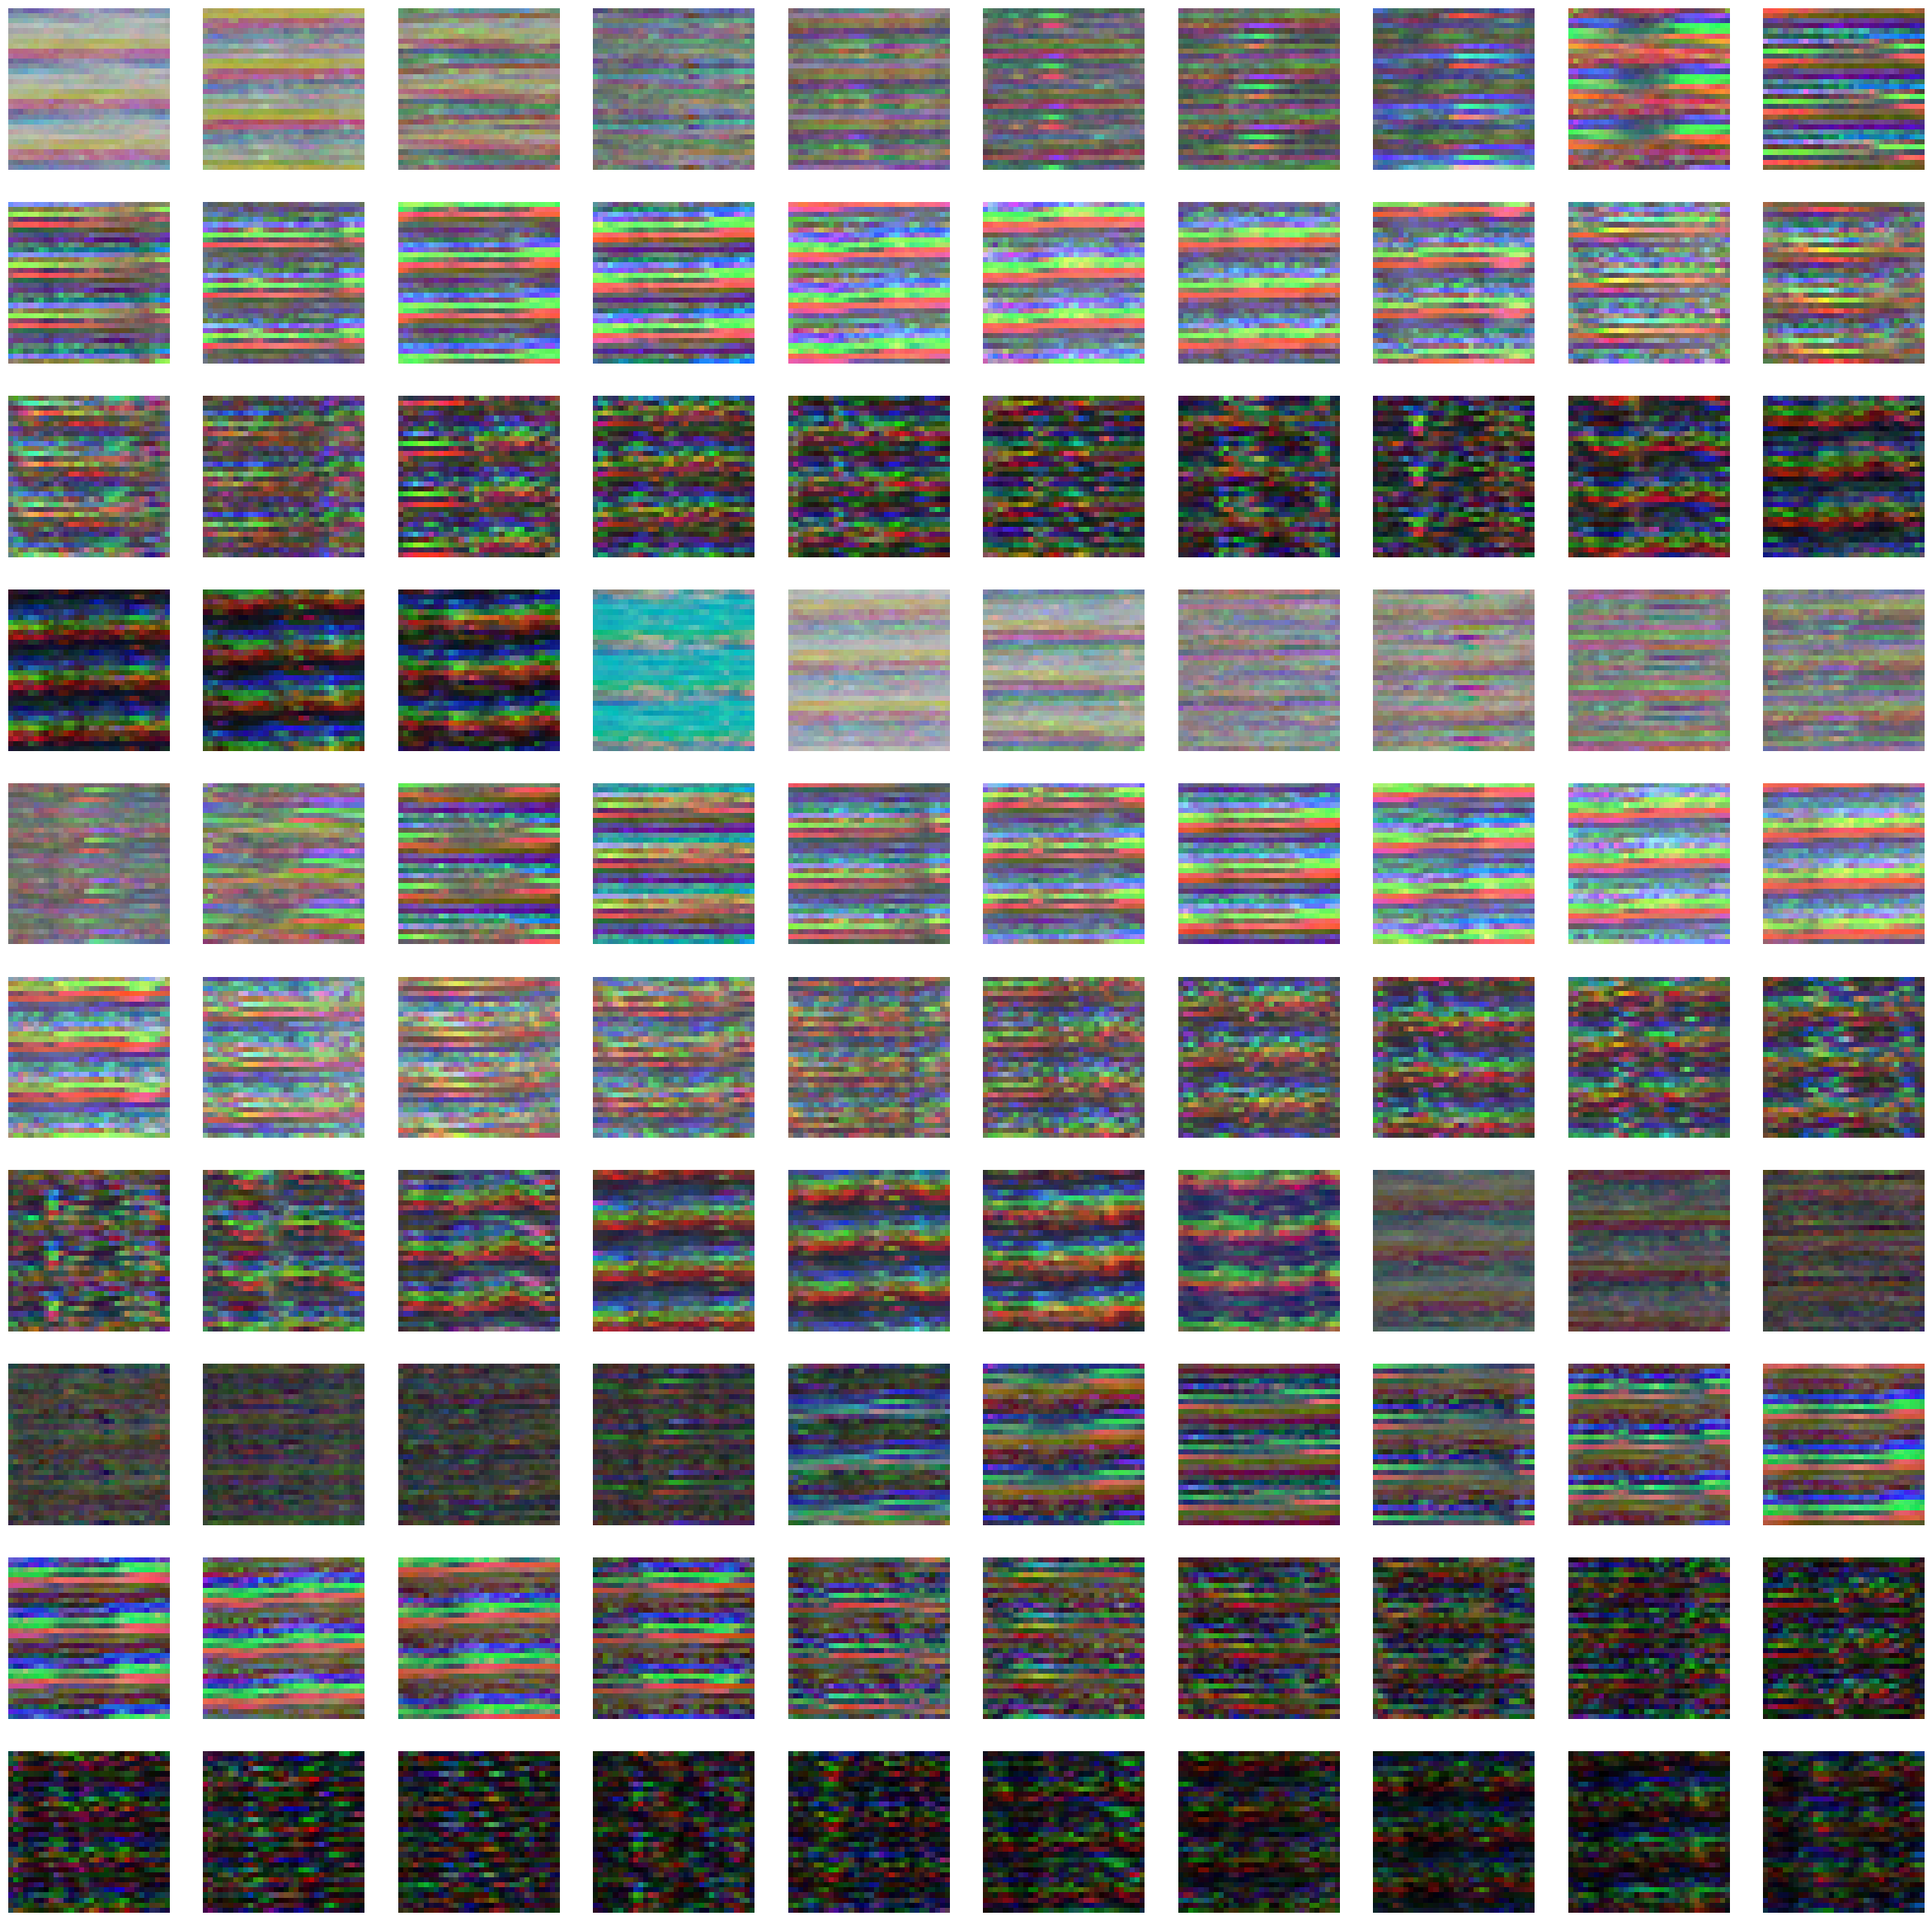

In [80]:
show_images(b.view(64, 10, 10, 3, 32, 32)[0].flatten(end_dim=1),nrows=10)

In [82]:
b.view(64, 3, 10,320//10, 10,320//10).shape

torch.Size([64, 3, 10, 32, 10, 32])

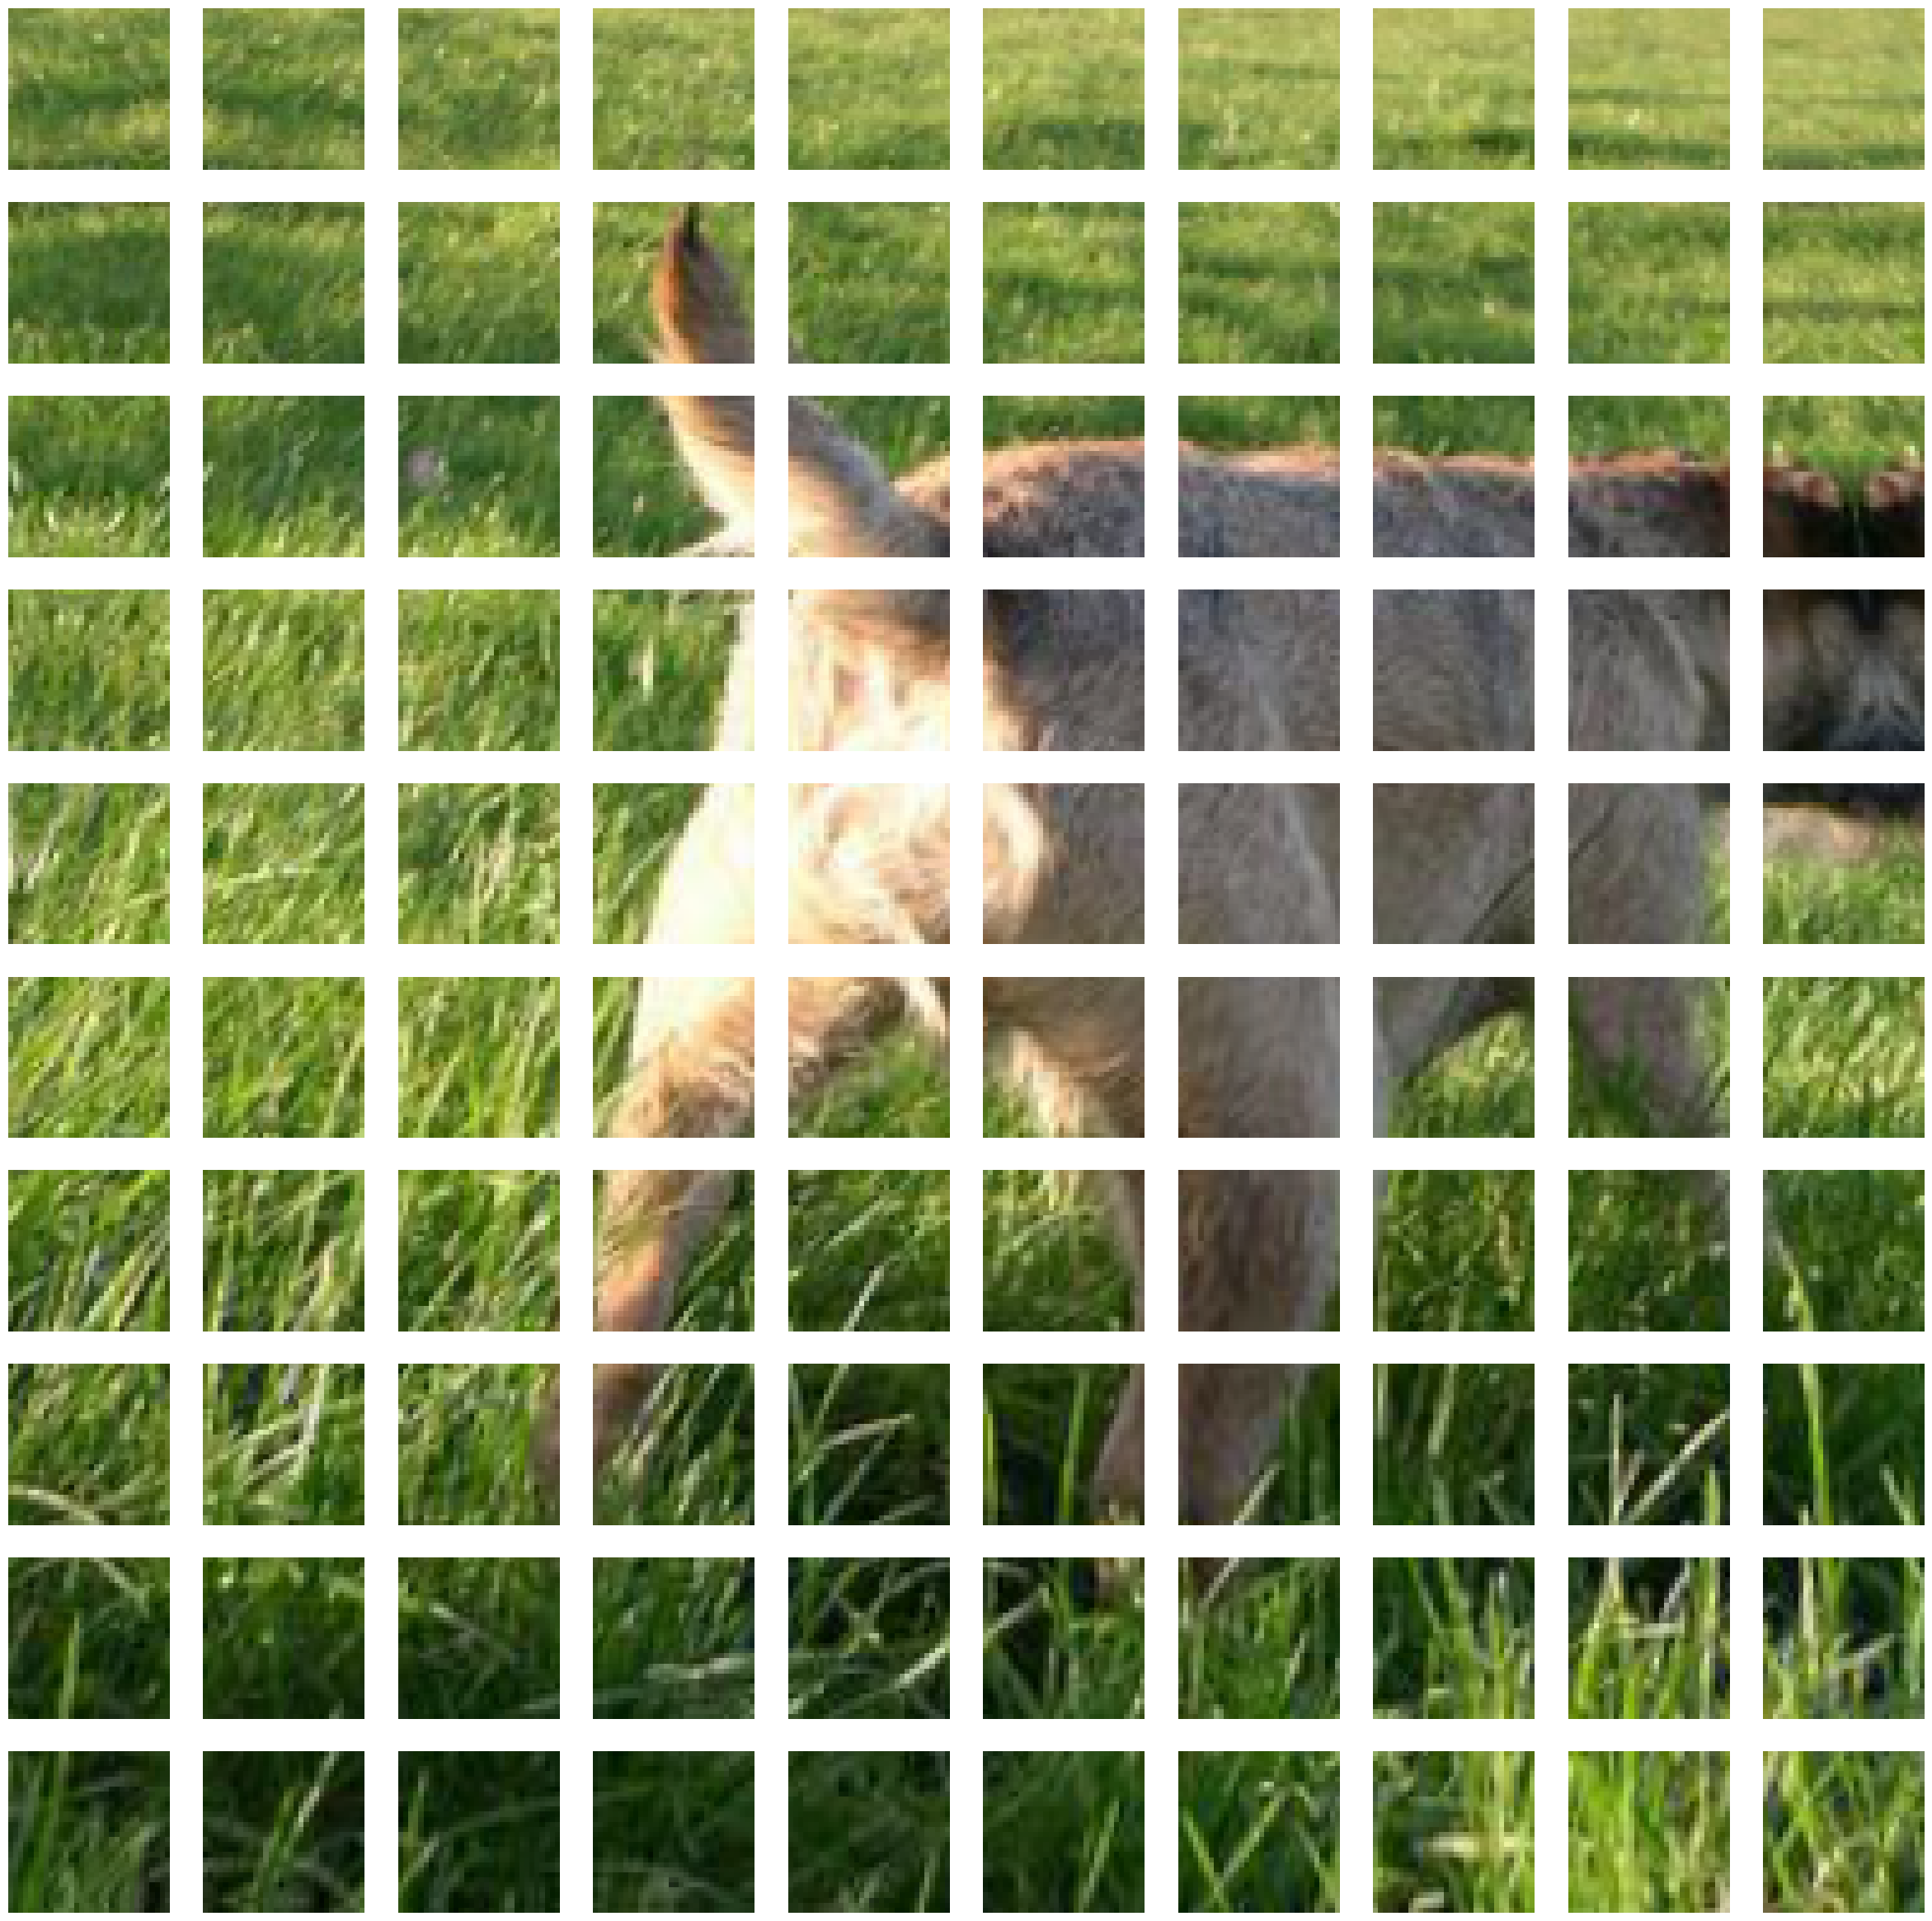

In [83]:
show_images(tiled_img[0].flatten(end_dim=1),nrows=10)

In [94]:
tiled_img[1].shape,(hash_loc==99)[0].shape

(torch.Size([10, 10, 3, 32, 32]), torch.Size([10, 10]))

In [97]:
tiled_img[8][(hash_loc==99)[8]].shape

torch.Size([15, 3, 32, 32])

###### How would select select the patches of the image that fall into our mode bucket? 

In [104]:
tiled_img[1][hash_loc[1]==199].shape

torch.Size([11, 3, 32, 32])

<AxesSubplot:>

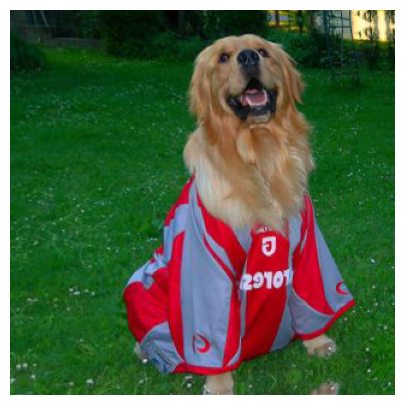

In [54]:
show_image(b[0])

Seems to detect "objects." Other images included scales for weight things, and sea shells. Dog nose, might be due to that space being close.  

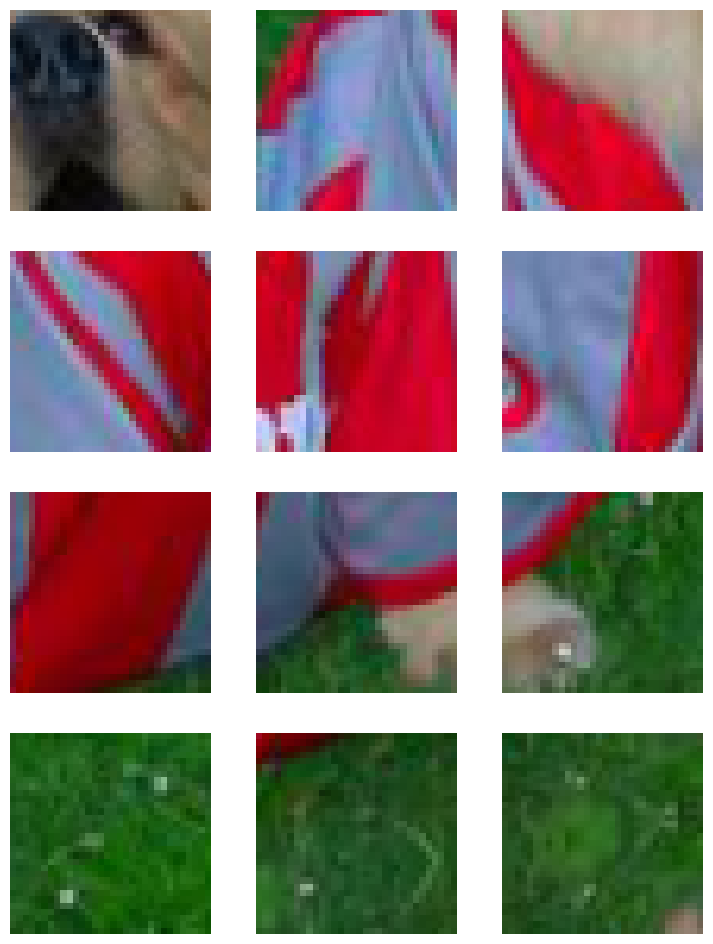

In [55]:
show_images(tiled_img[0][hash_loc[0]==199][:64],nrows=4)

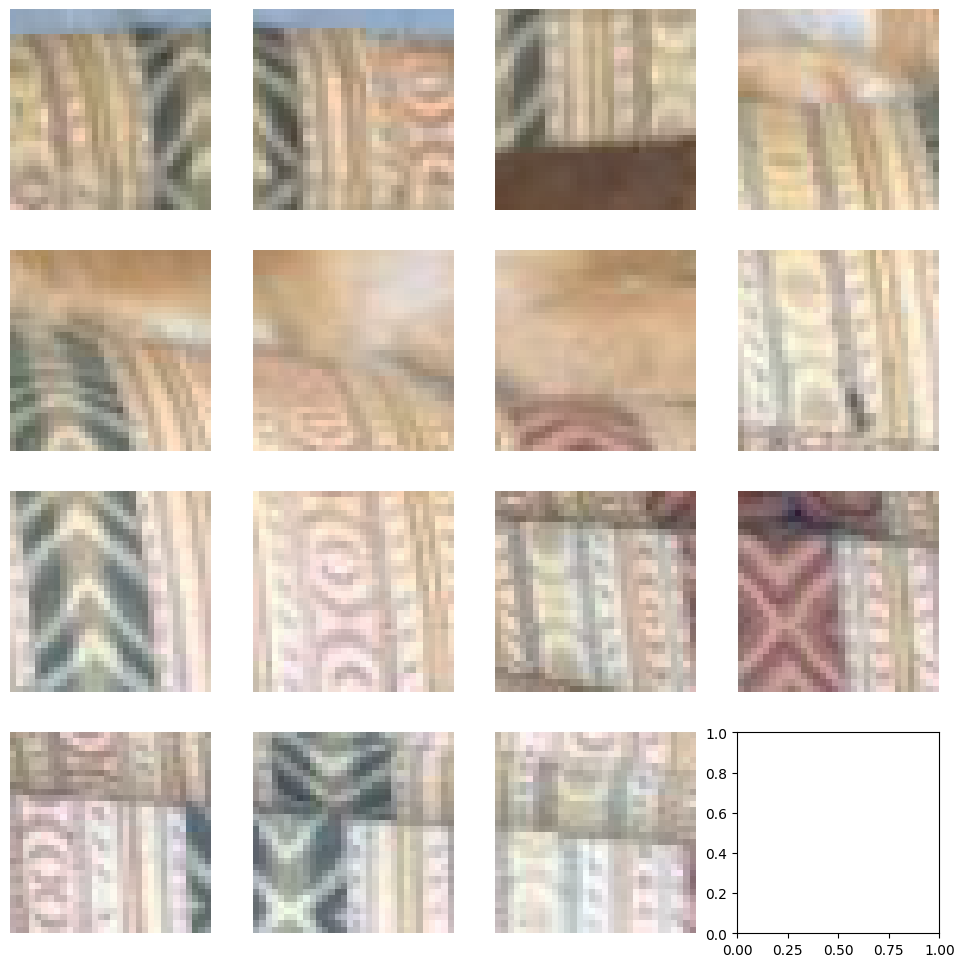

In [98]:
show_images(tiled_img[8][(hash_loc==99)[8]],nrows=4)

<AxesSubplot:>

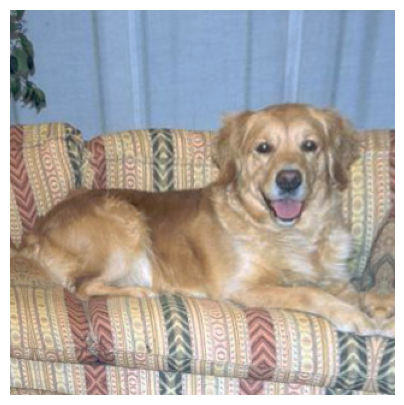

In [101]:
show_image(b[8])

In [103]:
len(dls.dataset)*10*10

1295200

In [104]:
1295200/256

5059.375